In [7]:
import os
import sys
from pathlib import Path

sys.path.append("..")

import albumentations as albu
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import numpy as np
import torch

# 画像の読み出し

In [8]:
fig_dir_pth = os.path.join("..", "assets", "jupyter_fig")

# Path オブジェクトの作成
p = Path(fig_dir_pth)
fig_pth_list = list(p.glob("*.png"))

print(fig_pth_list)

[PosixPath('../assets/jupyter_fig/binary.png'), PosixPath('../assets/jupyter_fig/page.png')]


外部ライブラリのなかには `Path` を受け付けないものもあります。軽く調べたところ、`numpy.loadtxt(Path_obj)` や `pandas.read_csv(Path_obj)` は正常にファイルを開けましたが、`cv2.imread(Path_obj)` はエラーになりました。
Pathオブジェクトを通常の文字列に変換するには、`Path.as_posix` 関数を使います。あるいは、`str(Path)` のようにキャストしてもよいです。

参考: [Pythonでフォルダ内のファイルリストを取得する](https://qiita.com/amowwee/items/e63b3610ea750f7dba1b)

In [9]:
org_fig = [cv2.imread(pth.as_posix()) for pth in fig_pth_list]
# print(org_fig)

In [10]:
def DataGenerator(root_dir: str, exp: str = ".png", transform=None):
    # Path オブジェクトの作成
    p = Path(fig_dir_pth)
    fig_pth_list = list(p.glob(f"*{exp}"))
    i = 0
    fig = []
    while True:
        org_fig = cv2.imread(fig_pth_list[i].as_posix())
        fig.append(org_fig)

        if transform:
            transformed_img = transform(image = org_fig)
            fig.append(transformed_img["image"])
        else:
            zero = np.zeros((org_fig.shape[0], org_fig.shape[1]))
            fig.append(zero)
        yield fig

In [11]:
from typing import Union

import torch.utils.data as data
import skimage.io as io
from lib.utils.base_utils import GetImgFpsAndLabels, LoadImgAndResize

class AugmentationDataset(data.Dataset):
    def __init__(self, root_dir: str, transforms: Union[albu.Compose, None]=None):
        self.root_dir = root_dir
        (self.cls_names,
         self.cls_to_idx,
         self.img_fps,
         self.targets,
         _) = GetImgFpsAndLabels(self.root_dir)

        self.transforms = transforms

    def __getitem__(self, index) -> np.ndarray:
        img_fp = self.img_fps[index]
        img = io.imread(img_fp)

        if self.transforms is not None:
            img = self.transforms(img = img)
        
        return img
    
    def __len__(self):
        return len(self.img_fps)

In [12]:
dataset = AugmentationDataset(fig_dir_pth)
data_loader = torch.utils.data.DataLoader(
    dataset
)

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img = next(gen)

    fig = plt.figure(figsize=(10, 5))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.1)
    
    for i in range(2):
        ax = plt.Subplot(fig, outerGrid[i])
        ax.imshow(img[i])
        # ax.axis('off')
        fig.add_subplot(ax)
    plt.show()

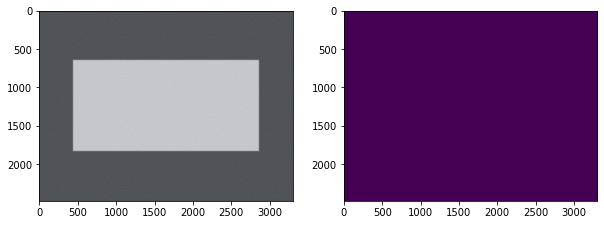

In [14]:
img_gen = DataGenerator(root_dir=fig_dir_pth)
visualizeGenerator(img_gen)

# 2. [Albmentations](https://github.com/albumentations-team/albumentations/) を用いたデータ拡張

## 2.1.1 Affine 変換（スケール変換）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

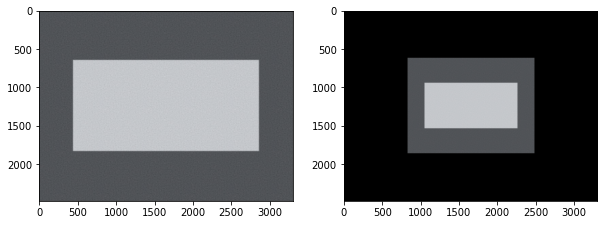

In [15]:
transform = albu.Compose([albu.Affine(scale=0.5)], p=1)
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.2 Affine 変換（平行移動）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

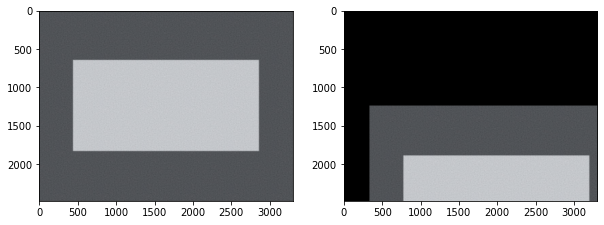

In [16]:
transform = albu.Compose([albu.Affine(translate_percent={"x":0.1, "y":0.5}, p=1)])
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.3 Affine 変換（回転）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

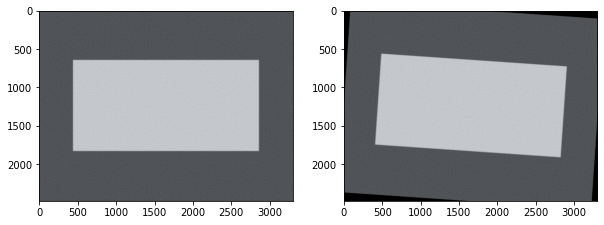

In [17]:
transform = albu.Compose([albu.Affine(rotate=(-90, 90), p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.1.4 Affine 変換（せん断）
参考: [albumentations.augmentations.geometric.transforms.Affine](https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.Affine)

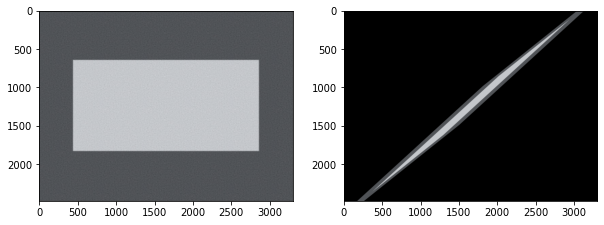

In [18]:
transform = albu.Compose([albu.Affine(shear=(-90, 90), p=1)])  # -90 ~ 90 の範囲でサンプリング（毎回回転角度が異なる）
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.2. CenterCrop
参考: [albumentations.augmentations.crops.transforms.CenterCrop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.CenterCrop)

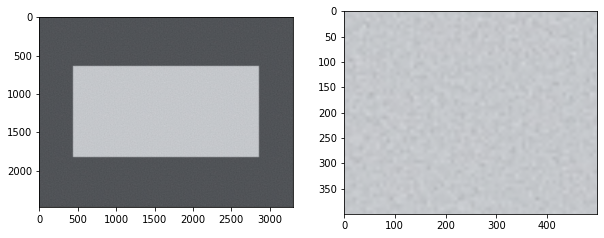

In [19]:
transform = albu.Compose([albu.CenterCrop(height=400, width=500, p=1)])
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

## 2.3. Crop
参考: [albumentations.augmentations.crops.transforms.Crop](https://albumentations.ai/docs/api_reference/augmentations/crops/transforms/#albumentations.augmentations.crops.transforms.Crop)

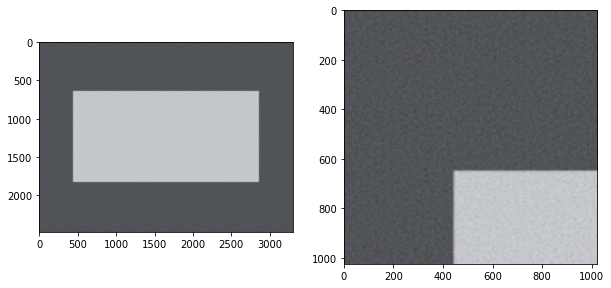

In [20]:
transform = albu.Compose([albu.Crop(x_min=0, y_min=0, x_max=1024, y_max=1024, p=1)])
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
visualizeGenerator(img_gen)

# OpenCV の特徴点マッチング

[Python + OpenCVで画像の類似度を求める](https://qiita.com/best_not_best/items/c9497ffb5240622ede01)

In [21]:
img_gen = DataGenerator(root_dir=fig_dir_pth, transform=transform)
img = next(img_gen)

ターゲット画像の特徴点を計算

In [22]:
detector = cv2.AKAZE_create()
(target_kp, target_des) = detector.detectAndCompute(img[0], None)

画像拡張を施した画像の特徴点を計算

In [23]:
(comparing_kp, comparing_des) = detector.detectAndCompute(img[1], None)

一致率を計算

In [24]:
# BFMatcherオブジェクトの生成
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
# Match descriptorsを生成
matches = bf.match(target_des, comparing_des)
# matchesをdescriptorsの似ている順にソートする 
matches = sorted(matches, key=lambda m:m.distance)

dist = [m.distance for m in matches]
ret = sum(dist) / len(dist)

print(ret)

82.18095238095238


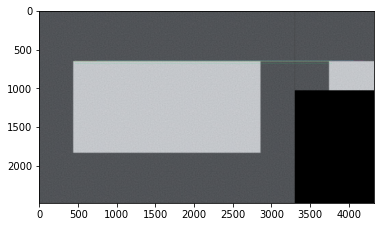

(<matplotlib.image.AxesImage at 0x7fddfa495fa0>, None)

In [25]:
# 検出結果を描画する
img_result = cv2.drawMatches(img[0], target_kp, img[1],comparing_kp, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#検出結果を描画した画像を出力する
plt.imshow(img_result),plt.show()

In [26]:
params = {
    ""
}

# Optuna を用いた一致率の最小化